In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import re

In [3]:
import datetime

In [4]:
import os

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from plotting import *

In [7]:
import matplotlib.dates as mdt

In [8]:
from matplotlib.ticker import MaxNLocator


#### Example of parsing profile line

In [9]:
pline = 'I1220 00:17:46.184228 128107 solver.cpp:291] [1] PROFILING BEGIN[Forward] Iteration 1'

In [10]:
pd = parse_profile_log_line(pline)
pd

{'iteration': 1,
 'pid': 128107,
 'prof_event': 'BEGIN',
 'prof_name': 'Forward',
 'remainder': '[1] PROFILING BEGIN[Forward] Iteration 1',
 'source_line': 'solver.cpp:291',
 'time': datetime.datetime(2016, 12, 20, 0, 17, 46, 184228),
 'worker_id': 1}

## Processing a bunch of profile lines

In [11]:
plines =[
    'I1220 00:17:46.184228 128107 solver.cpp:291] [1] PROFILING BEGIN[Forward] Iteration 1',
    'I1220 00:17:46.284228 128107 solver.cpp:291] [2] PROFILING BEGIN[Forward] Iteration 1',
    'I1220 00:17:47.084228 128107 solver.cpp:291] [2] PROFILING END[Forward] Iteration 1',
    'I1220 00:17:47.088228 128107 solver.cpp:291] [2] PROFILING BEGIN[Backward] Iteration 1',
    'I1220 00:17:47.184228 128107 solver.cpp:291] [1] PROFILING END[Forward] Iteration 1',
    'I1220 00:17:47.188228 128107 solver.cpp:291] [1] PROFILING BEGIN[Backward] Iteration 1',
    'I1220 00:17:48.088228 128107 solver.cpp:291] [2] PROFILING END[Backward] Iteration 1',
    'I1220 00:17:48.188228 128107 solver.cpp:291] [1] PROFILING END[Backward] Iteration 1',
    'I1220 00:17:48.284228 128107 solver.cpp:291] [1] PROFILING BEGIN[Forward] Iteration 2',
    'I1220 00:17:48.384228 128107 solver.cpp:291] [2] PROFILING BEGIN[Forward] Iteration 2',
    'I1220 00:17:49.184228 128107 solver.cpp:291] [2] PROFILING END[Forward] Iteration 2',
    'I1220 00:17:49.188228 128107 solver.cpp:291] [2] PROFILING BEGIN[Backward] Iteration 2',
    'I1220 00:17:49.284228 128107 solver.cpp:291] [1] PROFILING END[Forward] Iteration 2',
    'I1220 00:17:49.288228 128107 solver.cpp:291] [1] PROFILING BEGIN[Backward] Iteration 2',
    'I1220 00:17:50.188228 128107 solver.cpp:291] [2] PROFILING END[Backward] Iteration 2',
    'I1220 00:17:50.288228 128107 solver.cpp:291] [1] PROFILING END[Backward] Iteration 2'
]

In [12]:
all_events = []

for line in plines:
    parsed_dict = parse_profile_log_line(line)
    if parsed_dict:
        all_events.append(parsed_dict)

Blue==Forward
Red==Backward


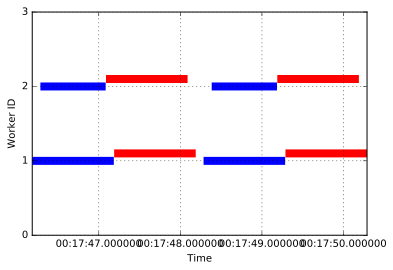

In [13]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.xaxis_date()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
#ax = plt.hlines()
for event in filter(lambda entry: entry['prof_event']=='BEGIN', all_events):
    # Find end event
    end_event = filter(lambda entry: (
                            entry['prof_event']=='END' and
                            entry['prof_name']==event['prof_name'] and
                            entry['worker_id']==event['worker_id'] and
                            entry['iteration']==event['iteration']
                ), all_events)[0]
    
    yvalue = event['worker_id']
    if event['prof_name']=='Backward':
        yvalue+=0.1
        color = 'red'
    else:
        color = 'blue'
        
    ax = plt.hlines(
        yvalue,
        mdt.date2num(event['time']), mdt.date2num(end_event['time']),
        color=color,
        linewidth=8
    )
plt.grid()
plt.ylabel('Worker ID')
plt.xlabel('Time')
plt.axis([None, None, 0, None]);
print 'Blue==Forward'
print 'Red==Backward'

## APPENDIX: New-style loss loading (not used yet) 

#### Example of parsing loss line

In [9]:
line = 'I1220 00:17:46.184228 128107 solver.cpp:291] [36] Iteration 1, loss = 0'
line = 'I1220 00:17:47.069375 128184 solver.cpp:291] [46] Iteration 3, loss = -3.74019e-06'

In [10]:
pd = parse_loss_log_line(line)
pd

{'iteration': 3,
 'loss': -3.74019e-06,
 'pid': 128184,
 'remainder': '[46] Iteration 3, loss = -3.74019e-06',
 'source_line': 'solver.cpp:291',
 'time': datetime.datetime(2016, 12, 20, 0, 17, 47, 69375),
 'worker_id': 46}

#### Example of loading losses for file with new code

In [11]:
all_losses = load_loss_info(logfile)

filtdict = filter(lambda entry: entry['worker_id']==46,all_losses)

filtdict[:3]

NameError: name 'logfile' is not defined